## Mounting Drive, Downloading dataset & extracting zip file 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/MyDrive/5554

/content/drive/MyDrive/5554


In [3]:
!wget https://data.mendeley.com/public-files/datasets/tywbtsjrjv/files/b4e3a32f-c0bd-4060-81e9-6144231f2520/file_downloaded

--2022-11-28 02:05:24--  https://data.mendeley.com/public-files/datasets/tywbtsjrjv/files/b4e3a32f-c0bd-4060-81e9-6144231f2520/file_downloaded
Resolving data.mendeley.com (data.mendeley.com)... 162.159.130.86, 162.159.133.86
Connecting to data.mendeley.com (data.mendeley.com)|162.159.130.86|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/349ac012-2948-4172-bbba-3bf8f76596fd [following]
--2022-11-28 02:05:25--  https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/349ac012-2948-4172-bbba-3bf8f76596fd
Resolving prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)... 52.218.29.56, 52.218.96.155, 52.218.25.200, ...
Connecting to prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)|52.218.29.56|:4

In [2]:
cd /content

/content


In [3]:
!mkdir dataset

In [ ]:
# Takes 1-2 mins
!unzip drive/MyDrive/5554/Plant_leaf_diseases_dataset_with_augmentation.zip -d /content/dataset/

## Importing Libraries

In [5]:
import numpy as np
import pickle
import cv2
import os
import tensorflow
import pathlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import shutil as sh
import pandas as pd
from tqdm import tqdm
from os import listdir
import tensorflow as tf
from pathlib import Path
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split

## Creating a curated dataset for multiclass classification

In [6]:
classes = os.listdir("/content/dataset/Plant_leave_diseases_dataset_with_augmentation")

In [7]:
classes

['Tomato___Target_Spot',
 'Peach___Bacterial_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Blueberry___healthy',
 'Apple___Apple_scab',
 'Soybean___healthy',
 'Grape___Black_rot',
 'Tomato___Early_blight',
 'Cherry___healthy',
 'Tomato___Septoria_leaf_spot',
 'Peach___healthy',
 'Tomato___Bacterial_spot',
 'Strawberry___Leaf_scorch',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Potato___Late_blight',
 'Pepper,_bell___healthy',
 'Grape___Esca_(Black_Measles)',
 'Cherry___Powdery_mildew',
 'Corn___Common_rust',
 'Raspberry___healthy',
 'Apple___Black_rot',
 'Tomato___Tomato_mosaic_virus',
 'Apple___Cedar_apple_rust',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Strawberry___healthy',
 'Background_without_leaves',
 'Potato___Early_blight',
 'Potato___healthy',
 'Grape___healthy',
 'Corn___Northern_Leaf_Blight',
 'Squash___Powdery_mildew',
 'Corn___healthy',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Apple___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Orange___Hau

In [8]:
classes = [x for x in classes if x !='Background_without_leaves']

In [9]:
len(classes)

38

## Dataset for ImageDataGenerator

In [10]:
root_dir = '/content/dataset/Plant_leave_diseases_dataset_with_augmentation/'

In [11]:
#generating dataframes of images and labels
image_list = []
label_list = []

try:
  for folder in tqdm(classes):
    img_paths = os.listdir(root_dir + folder + "/")
    for img_path in img_paths:
      source = root_dir+folder+"/"+img_path
      if source.endswith(".jpg")==True or source.endswith(".JPG")==True:
          image_list.append(source)
          label_list.append(folder)
except Exception as e:
    print(f"Error : {e}")
data = pd.DataFrame()
data['FileName']= image_list
data['Label']= label_list
data.shape

100%|██████████| 38/38 [00:00<00:00, 444.84it/s]


(60341, 2)

In [12]:
data

FileName                 Label
0      /content/dataset/Plant_leave_diseases_dataset_...  Tomato___Target_Spot
1      /content/dataset/Plant_leave_diseases_dataset_...  Tomato___Target_Spot
2      /content/dataset/Plant_leave_diseases_dataset_...  Tomato___Target_Spot
3      /content/dataset/Plant_leave_diseases_dataset_...  Tomato___Target_Spot
4      /content/dataset/Plant_leave_diseases_dataset_...  Tomato___Target_Spot
...                                                  ...                   ...
60336  /content/dataset/Plant_leave_diseases_dataset_...      Tomato___healthy
60337  /content/dataset/Plant_leave_diseases_dataset_...      Tomato___healthy
60338  /content/dataset/Plant_leave_diseases_dataset_...      Tomato___healthy
60339  /content/dataset/Plant_leave_diseases_dataset_...      Tomato___healthy
60340  /content/dataset/Plant_leave_diseases_dataset_...      Tomato___healthy

[60341 rows x 2 columns]

In [13]:
# Split sizes (Stratified splitting to ensure each set has similar class distribution)
train_size = 0.7
val_size = 0.15
test_size = 0.15

In [14]:
# Split (train)
train, data_ = train_test_split(data, train_size=train_size, stratify=data['Label'])

In [15]:
train.shape

(42238, 2)

In [16]:
data_.shape #remaining

(18103, 2)

In [17]:
# Split (test)
test, val = train_test_split(data_, train_size=0.5, stratify=data_['Label'])

In [18]:
test.shape

(9051, 2)

In [19]:
val.shape

(9052, 2)

In [20]:
# Get counts for each class
train_counts = {}
for index, row in train.iterrows():
  if row['Label'] in train_counts.keys():
    train_counts[row['Label']]+=1
  else:
    train_counts[row['Label']]=1

val_counts = {}
for index, row in val.iterrows():
  if row['Label'] in val_counts.keys():
    val_counts[row['Label']]+=1
  else:
    val_counts[row['Label']]=1

test_counts = {}
for index, row in test.iterrows():
  if row['Label'] in test_counts.keys():
    test_counts[row['Label']]+=1
  else:
    test_counts[row['Label']]=1

In [21]:
# View distributions
pd.DataFrame({
    "train": train_counts,
    "val": val_counts,
    "test": test_counts
}).T.fillna(0)

Tomato___Tomato_Yellow_Leaf_Curl_Virus  Tomato___Leaf_Mold  \
train                                    3750                 700   
val                                       804                 150   
test                                      803                 150   

       Grape___Esca_(Black_Measles)  Grape___Black_rot  Soybean___healthy  \
train                           968                826               3563   
val                             207                177                764   
test                            208                177                763   

       Tomato___Spider_mites Two-spotted_spider_mite  \
train                                           1173   
val                                              252   
test                                             251   

       Tomato___Septoria_leaf_spot  Blueberry___healthy  Tomato___healthy  \
train                         1240                 1051              1114   
val                            266                  225               239   
test                           265                  226               238   

       Apple___Black_rot  ...  Peach___healthy  Corn___Common_rust  \
train                700  ...              700                 834   
val                  150  ...              150                 179   
test                 150  ...              150                 179   

       Cherry___healthy  Pepper,_bell___healthy  Tomato___Early_blight  \
train               700                    1034                    700   
val                 150                     221                    150   
test                150                     222                    150   

       Tomato___Bacterial_spot  Apple___Apple_scab  Grape___healthy  \
train                     1489                 700              700   
val                        319                 150              150   
test                       319                 150              150   

       Potato___healthy  Tomato___Target_Spot  
train               700                   983  
val                 150                   210  
test                150                   211  

[3 rows x 38 columns]

In [22]:
base_path = "/content/final_dataset/"
folders = ["train", "val", "test"] 

for f in folders:
  for c in classes:
    path = base_path + f + "/" + c
    p = pathlib.Path(path)
    p.mkdir(parents=True, exist_ok=True)

In [23]:
base_path = "/content/final_dataset/"

for index, row in tqdm(train.iterrows()):
  img_name = row['FileName'].split("/")[-1]
  destination = base_path + "train" + "/" + row['Label'] + "/" + img_name
  sh.copyfile(row['FileName'], destination)

42238it [00:10, 4176.51it/s]


In [24]:
base_path = "/content/final_dataset/"

for index, row in tqdm(val.iterrows()):
  img_name = row['FileName'].split("/")[-1]
  destination = base_path + "val" + "/" + row['Label'] + "/" + img_name
  sh.copyfile(row['FileName'], destination)

9052it [00:01, 4534.83it/s]


In [25]:
base_path = "/content/final_dataset/"

for index, row in tqdm(test.iterrows()):
  img_name = row['FileName'].split("/")[-1]
  destination = base_path + "test" + "/" + row['Label'] + "/" + img_name
  sh.copyfile(row['FileName'], destination)

9051it [00:01, 4525.73it/s]


## Model

In [26]:
def cnn(input_shape = (256, 256, 3), lr = 1e-3, factor = 64):
    img_input = layers.Input(input_shape)
    X = layers.Conv2D(factor, 3, padding = 'same', activation = 'relu')(img_input)
    X = layers.MaxPooling2D(pool_size = (2, 2))(X)
    X = layers.Conv2D(factor*2, 3, padding = 'same', activation = 'relu')(X)
    X = layers.MaxPooling2D(pool_size = (2, 2))(X)
    X = layers.Conv2D(factor*4, 3, padding = 'same', activation = 'relu')(X)
    X = layers.MaxPooling2D(pool_size = (2, 2))(X)
    X = layers.Conv2D(factor*8, 3, padding = 'same', activation = 'relu')(X)
    X = layers.MaxPooling2D(pool_size = (2, 2))(X)
    X = layers.Conv2D(factor*16, 3, padding = 'same', activation = 'relu')(X)
    X = layers.MaxPooling2D(pool_size = (2, 2))(X)
    X = layers.Flatten()(X)
    X = layers.Dense(128, activation = 'relu')(X)
    X = layers.Dropout(rate=0.5)(X)
    X = layers.Dense(38)(X)
    X = layers.Activation('softmax', dtype='float32', name='predictions')(X)
    model = models.Model(inputs = img_input, outputs = X)
    model.compile(optimizer = Adam(lr), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    return model

## Load Dataset

In [27]:
batch_size = 64
target_size = (256, 256)
color_mode = "rgb"
dataset = '/content/final_dataset'
train_datagen = ImageDataGenerator(rescale=1/255)
val_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)
train_generator = train_datagen.flow_from_directory(f'{dataset}/train/', target_size=target_size, batch_size=batch_size, class_mode='binary', color_mode=color_mode)
val_generator = val_datagen.flow_from_directory(f'{dataset}/val/', target_size=target_size, batch_size=batch_size, class_mode='binary', color_mode=color_mode)
test_generator = test_datagen.flow_from_directory(f'{dataset}/test/', target_size=target_size, batch_size=batch_size, class_mode='binary', color_mode=color_mode)

Found 42238 images belonging to 38 classes.
Found 9052 images belonging to 38 classes.
Found 9051 images belonging to 38 classes.


In [28]:
train_generator.class_indices

{'Apple___Apple_scab': 0,
 'Apple___Black_rot': 1,
 'Apple___Cedar_apple_rust': 2,
 'Apple___healthy': 3,
 'Blueberry___healthy': 4,
 'Cherry___Powdery_mildew': 5,
 'Cherry___healthy': 6,
 'Corn___Cercospora_leaf_spot Gray_leaf_spot': 7,
 'Corn___Common_rust': 8,
 'Corn___Northern_Leaf_Blight': 9,
 'Corn___healthy': 10,
 'Grape___Black_rot': 11,
 'Grape___Esca_(Black_Measles)': 12,
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13,
 'Grape___healthy': 14,
 'Orange___Haunglongbing_(Citrus_greening)': 15,
 'Peach___Bacterial_spot': 16,
 'Peach___healthy': 17,
 'Pepper,_bell___Bacterial_spot': 18,
 'Pepper,_bell___healthy': 19,
 'Potato___Early_blight': 20,
 'Potato___Late_blight': 21,
 'Potato___healthy': 22,
 'Raspberry___healthy': 23,
 'Soybean___healthy': 24,
 'Squash___Powdery_mildew': 25,
 'Strawberry___Leaf_scorch': 26,
 'Strawberry___healthy': 27,
 'Tomato___Bacterial_spot': 28,
 'Tomato___Early_blight': 29,
 'Tomato___Late_blight': 30,
 'Tomato___Leaf_Mold': 31,
 'Tomato___Septor

## Training

In [29]:
model_path = 'models/'
Path(model_path).mkdir(parents=True, exist_ok = True)
checkpointer = ModelCheckpoint(model_path+f'/cnn_'+'epochs:{epoch:02d}_acc:{val_accuracy:.4f}.h5', monitor = 'val_loss', save_best_only = True, verbose = 0, mode = 'auto')
earlystopper = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 0, mode = 'auto')
reduceLR = ReduceLROnPlateau(monitor = 'val_loss', factor = 1/np.sqrt(10), patience = 3, cooldown = 1, verbose = 0, mode = 'auto')
model = cnn((256,256,3))
history = model.fit(train_generator, steps_per_epoch = len(train_generator), verbose = 2, epochs = 50, callbacks = [checkpointer, earlystopper, reduceLR], validation_data=val_generator, validation_steps = len(val_generator))

Epoch 1/50
660/660 - 265s - loss: 2.6482 - accuracy: 0.2963 - val_loss: 1.4413 - val_accuracy: 0.5956 - lr: 0.0010 - 265s/epoch - 402ms/step
Epoch 2/50
660/660 - 252s - loss: 1.5544 - accuracy: 0.5343 - val_loss: 0.9033 - val_accuracy: 0.7283 - lr: 0.0010 - 252s/epoch - 382ms/step
Epoch 3/50
660/660 - 253s - loss: 1.1617 - accuracy: 0.6376 - val_loss: 0.6478 - val_accuracy: 0.7970 - lr: 0.0010 - 253s/epoch - 384ms/step
Epoch 4/50
660/660 - 253s - loss: 0.9508 - accuracy: 0.6978 - val_loss: 0.4788 - val_accuracy: 0.8437 - lr: 0.0010 - 253s/epoch - 383ms/step
Epoch 5/50
660/660 - 253s - loss: 0.7792 - accuracy: 0.7479 - val_loss: 0.3990 - val_accuracy: 0.8741 - lr: 0.0010 - 253s/epoch - 383ms/step
Epoch 6/50
660/660 - 253s - loss: 0.6515 - accuracy: 0.7847 - val_loss: 0.3337 - val_accuracy: 0.8949 - lr: 0.0010 - 253s/epoch - 383ms/step
Epoch 7/50
660/660 - 253s - loss: 0.5645 - accuracy: 0.8132 - val_loss: 0.3062 - val_accuracy: 0.9033 - lr: 0.0010 - 253s/epoch - 383ms/step
Epoch 8/50
66

## Saving model weights

In [30]:
source = "/content/models"
destination = "/content/drive/MyDrive/5554/multiclass/models"
sh.copytree(source, destination)

'/content/drive/MyDrive/5554/multiclass/models'

## Printing, plotting, and saving metrics

In [31]:
print(model.evaluate(test_generator, steps = 2*len(test_generator)))

142/284 [==============>...............] - ETA: 25s - loss: 0.1372 - accuracy: 0.9785

284/284 [==============================] - 26s 92ms/step - loss: 0.1372 - accuracy: 0.9785
[0.13719771802425385, 0.9784554243087769]


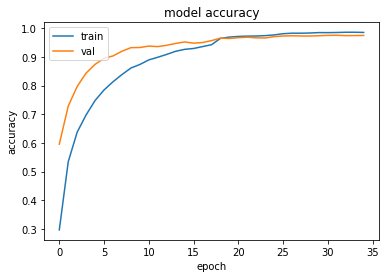

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('accuracy.png')
plt.show()

In [33]:
source = "/content/accuracy.png"
destination = "/content/drive/MyDrive/5554/multiclass/accuracy.png"
sh.copyfile(source, destination)

'/content/drive/MyDrive/5554/multiclass/accuracy.png'

In [34]:
# storing history value
with open('HistoryDict.pickle', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [35]:
source = "/content/HistoryDict.pickle"
destination = "/content/drive/MyDrive/5554/multiclass/HistoryDict.pickle"
sh.copyfile(source, destination)

'/content/drive/MyDrive/5554/multiclass/HistoryDict.pickle'

## Getting predictions

In [36]:
weights_path = "/content/models/cnn_epochs:30_acc:0.9738.h5"
pred_model = load_model(weights_path)

In [37]:
pred_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 256)       295168

In [58]:
def random_prediction():
  path = "/content/dataset/Plant_leave_diseases_dataset_with_augmentation/"
  folder_name = random.choice(os.listdir(path))
  folder_path = path + folder_name +"/"
  img_name = random.choice(os.listdir(folder_path))
  img_path = folder_path + img_name
  img = cv2.imread(img_path)
  rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.title(folder_name + "__" + img_name)
  plt.imshow(rgb_img)
  plt.show()

  img_array = rgb_img / 255
  img_array = img_array.reshape(1, 256, 256, 3)

  prediction = list(train_generator.class_indices.keys())[list(train_generator.class_indices.values()).index(tf.argmax(pred_model.predict(img_array), 1).numpy()[0])]
  print("Prediction : {}".format(prediction))

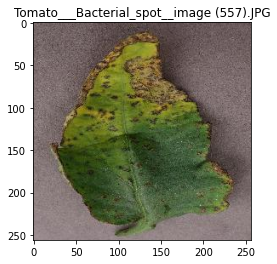

1/1 [==============================] - 0s 16ms/step
Prediction : Tomato___Bacterial_spot


In [59]:
random_prediction()